# 6. Frame Selected Discriminality and ICC

In [1]:
from src import *

In [2]:
import pingouin

## Description

We evaluate frame selected's discriminality and ICC values. 

GOAL: Compute frame selected's discriminality and ICC values. 

## Table of Contents
- [Frame selected (by emotion intensity) and discrim / ICC](#emointense)
- [Frame selected (by 3FA) and discrim / ICC](#3fa)

In [14]:
D = lambda x,y: ((x-y)**2).sum(axis=1)
distance = lambda x,y: 1 - pearson_correlation(x,y)

def compute_discriminality(samples):
    """
    Compute Value of discriminality within a distance/similarity matrix (2d inputs)
    """
    
    nb_smp = samples.shape[0]
    dist_mat = np.zeros((nb_smp,nb_smp))

    for k in range(nb_smp):
        for j in range(nb_smp):
            dist_mat[k,j] = distance(samples[k],samples[j])

    discrim = []
    for k in range(nb_smp//2):
        sample_size = nb_smp-1 # remove 1 for identity
        discrim.append(np.sum(dist_mat[k][30+k] <= dist_mat[k])/sample_size)
    
    return np.mean(discrim)

<a class="anchor" id="emointense"></a>
## Frame selected (by emotion) gradients

In [18]:
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]
thresholds = s10 + s20 + s25 + s33 + s50

In [4]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

#### Load frame selected and full movie gradients (individual level)

In [40]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/threshed_series/treshed_series.pkl')

if 'Rest' in f_series: del fselect_series['Rest']
if 'Rest' in total_series: del total_series['Rest']

In [ ]:
def persubject_grad(series, S):
    ## Warn: global variables here don't use it elsewhere
    fselect = {_id:[] for _id in series['Sintel'].keys()}
    # array swap
    for mname in S:
        tmp_dict = series[mname]

        for _id in tmp_dict:
            tmp_series = tmp_dict[_id]
            fselect[_id].append(tmp_series)

    # all movies gradients compute
    gradients = {}
    for _id in fselect:
        tmp_series = np.concatenate(fselect[_id])
        fc = FC(tmp_series)
        g = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        grad = g.gradients_

        fscore = D(grad.mean(axis=0), grad)
        gradients[_id] = fscore

    return gradients

def multiple_icc(test,retest):
    # test and retest multiple times along input arrays
    # test and retest are of format dict('target1': 1darray, 'target2': 1darray ...)
    icc_array = []
    n_iter = test[next(iter(test))].shape[0]
    for idx in range(n_iter):
        df = {'type': [], 'id': [], 'fscore': []}

        for _id in test.keys():
            df['id'] += [int(_id[1:])]
            df['fscore'] += [test[_id][idx]]
            df['type'] += ['test']

            df['id'] += [int(_id[1:])]
            df['fscore'] += [retest[_id][idx]]
            df['type'] += ['retest']

        df = pd.DataFrame.from_dict(df)

        icc = pingouin.intraclass_corr(data=df, targets='id', raters='type', ratings='fscore')
        icc_array.append(np.round(list(icc['ICC']),3)[2])
    
    return icc_array

#### Test-Retest classes

In [7]:
set1 = list(total_series.keys())[:len(total_series)//2]
set2 = list(total_series.keys())[len(total_series)//2:]

In [9]:
print(set1)
print(set2)

['ToClaireFromSonny', 'TheSecretNumber', 'Chatter', 'LessonLearned', 'Payload', 'AfterTheRain', 'Superhero']
['Sintel', 'TearsOfSteel', 'BetweenViewing', 'BigBuckBunny', 'YouAgain', 'Spaceman', 'FirstBite']


### Compute ICC across ID using as class the test or retest 

In [ ]:
icc_bounds = {}
for bound in tqdm(thresholds):
    fselected_series = f_series[1][bound]

    step_array = []
    for k in range(1,len(set1)+1):
        # Grouping test-retest
        fselect1_gradients = persubject_grad(fselected_series,set1[:k])
        fselect2_gradients = persubject_grad(fselected_series,set2[:k])

        icc_array = multiple_icc(fselect1_gradients, fselect2_gradients)
        step_array.append(icc_array)
    
    icc_bounds[bound] = step_array

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
step_iccfull = []
for k in range(1,len(set1)+1):
    # Grouping test-retest
    ftotal1_gradients = persubject_grad(total_series,set1[:k])
    ftotal2_gradients = persubject_grad(total_series,set2[:k])
    
    icc_fullarray = multiple_icc(ftotal1_gradients, ftotal2_gradients)
    step_iccfull.append(icc_fullarray)

#### Visualize results

/tmp/ipykernel_179948/1913960272.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(np.arange(0,8))


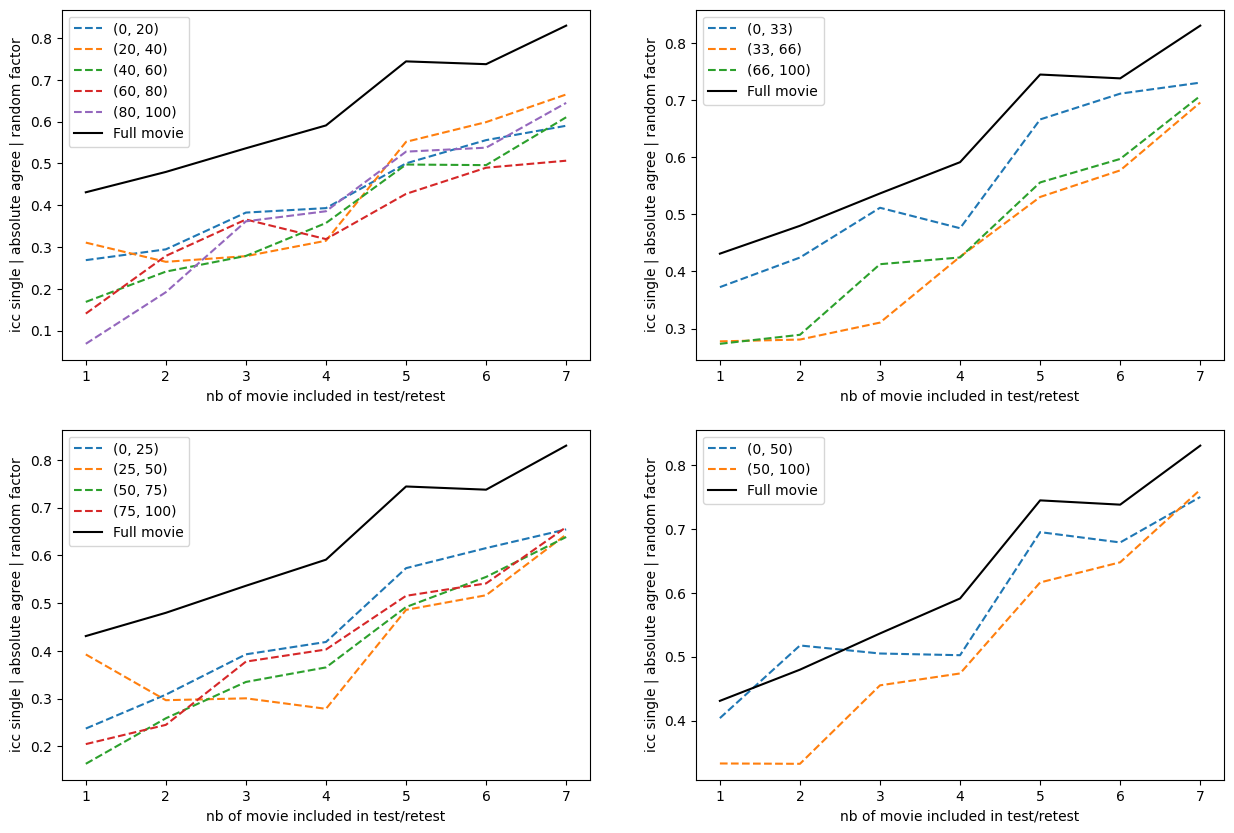

In [30]:
fig,ax = plt.subplots(2,2, figsize=(15,10))
for idx,bounds in enumerate([s20, s25, s33, s50]):
    r,c = idx%2, idx//2
    for k in range(len(bounds)):
        ax[r,c].plot(np.asarray([icc_bounds[s] for s in bounds]).mean(axis=-1)[k],
                linestyle='--', label='{}'.format(bounds[k]))

    ax[r,c].plot(np.asarray(step_iccfull).mean(axis=1), label='Full movie', color='k')


    ax[r,c].legend()
    ax[r,c].set_xlabel('nb of movie included in test/retest')
    ax[r,c].set_ylabel('icc single | absolute agree | random factor')
    ax[r,c].set_xticklabels(np.arange(0,8))

### Discriminality

In [21]:
dis_bounds = {}
for bound in tqdm(thresholds):
    fselected_series = f_series[1][bound]

    step_array = []
    for k in range(1,len(set1)+1):
        # Grouping test-retest
        fselect1_gradients = persubject_grad(fselected_series,set1[:k])
        fselect2_gradients = persubject_grad(fselected_series,set2[:k])
        samples = np.array(list(fselect1_gradients.values()) + list(fselect2_gradients.values()))
        
        dis_array = compute_discriminality(samples)
        step_array.append(dis_array)
    
    dis_bounds[bound] = step_array

  0%|          | 0/24 [00:00<?, ?it/s]

In [31]:
step_disfull = []
for k in range(1,len(set1)+1):
    # Grouping test-retest
    ftotal1_gradients = persubject_grad(total_series,set1[:k])
    ftotal2_gradients = persubject_grad(total_series,set2[:k])
    samples = np.array(list(ftotal1_gradients.values()) + list(ftotal2_gradients.values()))
    
    dis_fullarray = compute_discriminality(samples)
    step_disfull.append(dis_fullarray)

#### Visualize results

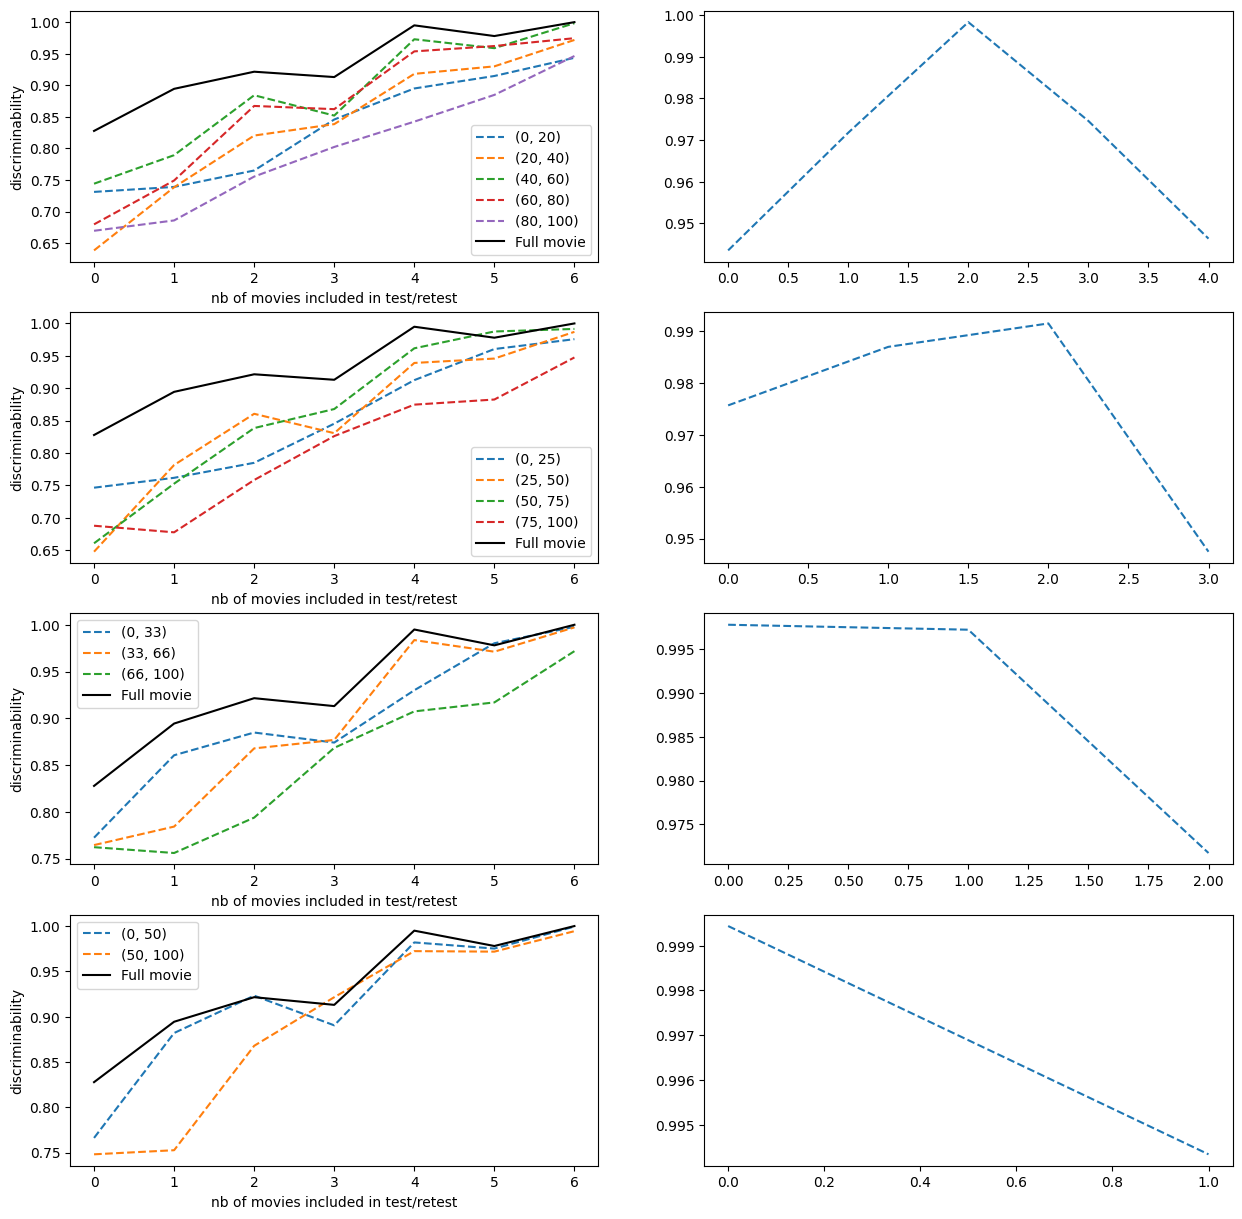

In [36]:
fig, ax = plt.subplots(4,2,figsize=(15,15))
for idx,bounds in enumerate([s20, s25, s33, s50]):
    for k in range(len(bounds)):
        ax[idx,0].plot(np.asarray([dis_bounds[s] for s in bounds])[k],linestyle='--', label=bounds[k])

    ax[idx,0].plot(np.asarray(step_disfull), label='Full movie', color='k')
    ax[idx,1].plot(np.asarray([dis_bounds[s][-1] for s in bounds]),linestyle='--')
    ax[idx,0].legend()
    ax[idx,0].set_xlabel("nb of movies included in test/retest")
    ax[idx,0].set_ylabel("discriminability")

<a class="anchor" id="3fa"></a>
## Frame selected (by 3FA) and discrim / ICC 

In [50]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]
thresholds = s5 + s10 + s20 + s25 + s33 + s50

In [51]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

#### Load frame selected and full movie gradients (individual level)

In [52]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/threshed_series/fa_treshed_series.pkl')

if 'Rest' in f_series: del fselect_series['Rest']
if 'Rest' in total_series: del total_series['Rest']

In [43]:
def persubject_grad(series, S):
    ## Warn: global variables here don't use it elsewhere
    fselect = {_id:[] for _id in series['Sintel'].keys()}
    # array swap
    for mname in S:
        tmp_dict = series[mname]

        for _id in tmp_dict:
            tmp_series = tmp_dict[_id]
            fselect[_id].append(tmp_series)

    # all movies gradients compute
    gradients = {}
    for _id in fselect:
        tmp_series = np.concatenate(fselect[_id])
        fc = FC(tmp_series)
        g = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        grad = g.gradients_

        fscore = D(grad.mean(axis=0), grad)
        gradients[_id] = fscore

    return gradients

def multiple_icc(test,retest):
    # test and retest multiple times along input arrays
    # test and retest are of format dict('target1': 1darray, 'target2': 1darray ...)
    icc_array = []
    n_iter = test[next(iter(test))].shape[0]
    for idx in range(n_iter):
        df = {'type': [], 'id': [], 'fscore': []}

        for _id in test.keys():
            df['id'] += [int(_id[1:])]
            df['fscore'] += [test[_id][idx]]
            df['type'] += ['test']

            df['id'] += [int(_id[1:])]
            df['fscore'] += [retest[_id][idx]]
            df['type'] += ['retest']

        df = pd.DataFrame.from_dict(df)

        icc = pingouin.intraclass_corr(data=df, targets='id', raters='type', ratings='fscore')
        icc_array.append(np.round(list(icc['ICC']),3)[2])
    
    return icc_array

#### Test-Retest classes

In [44]:
set1 = list(total_series.keys())[:len(total_series)//2]
set2 = list(total_series.keys())[len(total_series)//2:]

In [45]:
print(set1)
print(set2)

['ToClaireFromSonny', 'TheSecretNumber', 'Chatter', 'LessonLearned', 'Payload', 'AfterTheRain', 'Superhero']
['Sintel', 'TearsOfSteel', 'BetweenViewing', 'BigBuckBunny', 'YouAgain', 'Spaceman', 'FirstBite']


### Compute ICC across ID using as class the test or retest 

In [ ]:
per_fa = {}
for fa_nb in range(3):
    icc_bounds = {}
    for bound in tqdm(thresholds):
        fselected_series = f_series[fa_nb][bound]

        step_array = []
        for k in range(1,len(set1)+1):
            # Grouping test-retest
            fselect1_gradients = persubject_grad(fselected_series,set1[:k])
            fselect2_gradients = persubject_grad(fselected_series,set2[:k])

            icc_array = multiple_icc(fselect1_gradients, fselect2_gradients)
            step_array.append(icc_array)

        icc_bounds[bound] = step_array
    per_fa[fa_nb] = icc_bounds

  0%|          | 0/44 [00:00<?, ?it/s]

In [ ]:
step_iccfull = []
for k in range(1,len(set1)+1):
    # Grouping test-retest
    ftotal1_gradients = persubject_grad(total_series,set1[:k])
    ftotal2_gradients = persubject_grad(total_series,set2[:k])
    
    icc_fullarray = multiple_icc(ftotal1_gradients, ftotal2_gradients)
    step_iccfull.append(icc_fullarray)

#### Visualize results

/tmp/ipykernel_179948/1053533484.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(np.arange(0,8))


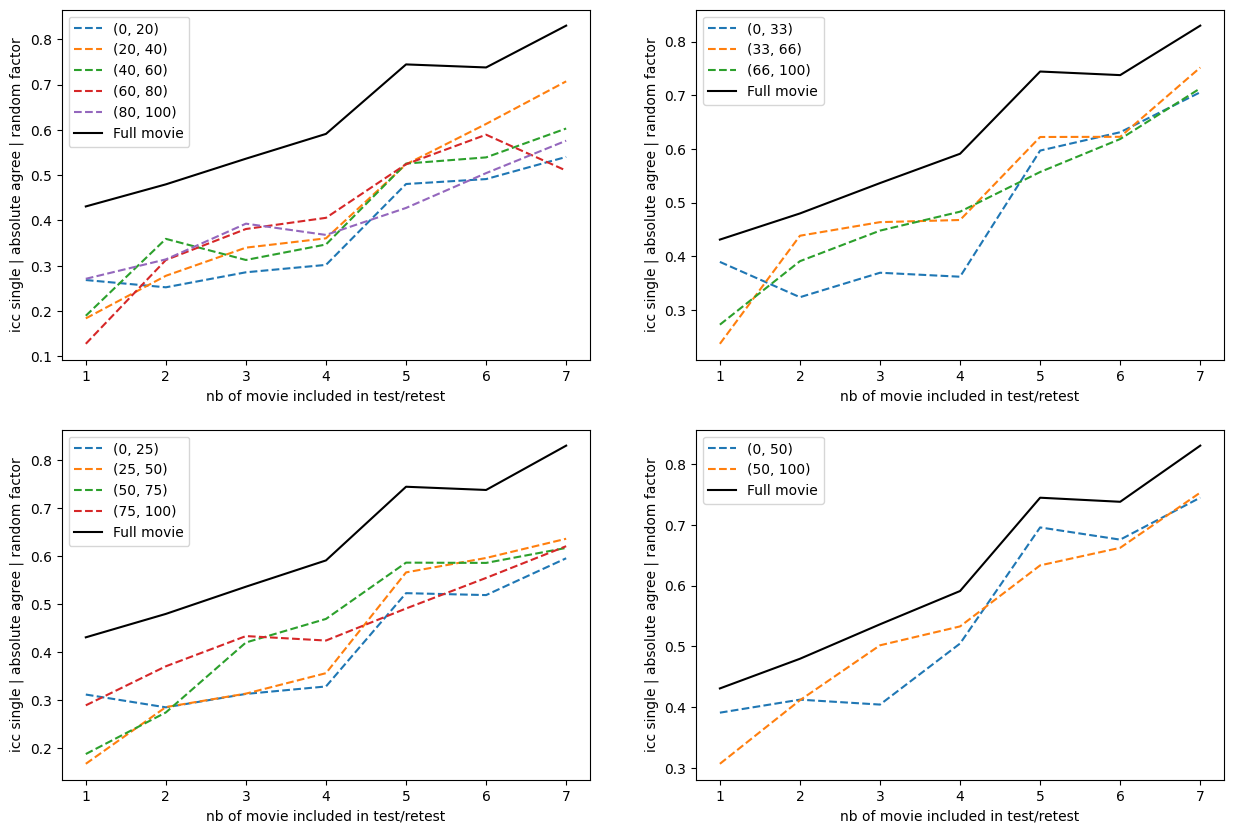

In [54]:
icc_bounds = per_fa[1]
fig,ax = plt.subplots(2,2, figsize=(15,10))
for idx,bounds in enumerate([s20, s25, s33, s50]):
    r,c = idx%2, idx//2
    for k in range(len(bounds)):
        ax[r,c].plot(np.asarray([icc_bounds[s] for s in bounds]).mean(axis=-1)[k],
                linestyle='--', label='{}'.format(bounds[k]))

    ax[r,c].plot(np.asarray(step_iccfull).mean(axis=1), label='Full movie', color='k')


    ax[r,c].legend()
    ax[r,c].set_xlabel('nb of movie included in test/retest')
    ax[r,c].set_ylabel('icc single | absolute agree | random factor')
    ax[r,c].set_xticklabels(np.arange(0,8))

### Discriminality

In [55]:
per_fa_dis = {}
for fa_nb in range(3):
    dis_bounds = {}
    for bound in tqdm(thresholds):
        fselected_series = f_series[fa_nb][bound]

        step_array = []
        for k in range(1,len(set1)+1):
            # Grouping test-retest
            fselect1_gradients = persubject_grad(fselected_series,set1[:k])
            fselect2_gradients = persubject_grad(fselected_series,set2[:k])
            samples = np.array(list(fselect1_gradients.values()) + list(fselect2_gradients.values()))

            dis_array = compute_discriminality(samples)
            step_array.append(dis_array)

        dis_bounds[bound] = step_array
    per_fa_dis[fa_nb] = dis_bounds

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [56]:
step_disfull = []
for k in range(1,len(set1)+1):
    # Grouping test-retest
    ftotal1_gradients = persubject_grad(total_series,set1[:k])
    ftotal2_gradients = persubject_grad(total_series,set2[:k])
    samples = np.array(list(ftotal1_gradients.values()) + list(ftotal2_gradients.values()))
    
    dis_fullarray = compute_discriminality(samples)
    step_disfull.append(dis_fullarray)

#### Visualize results

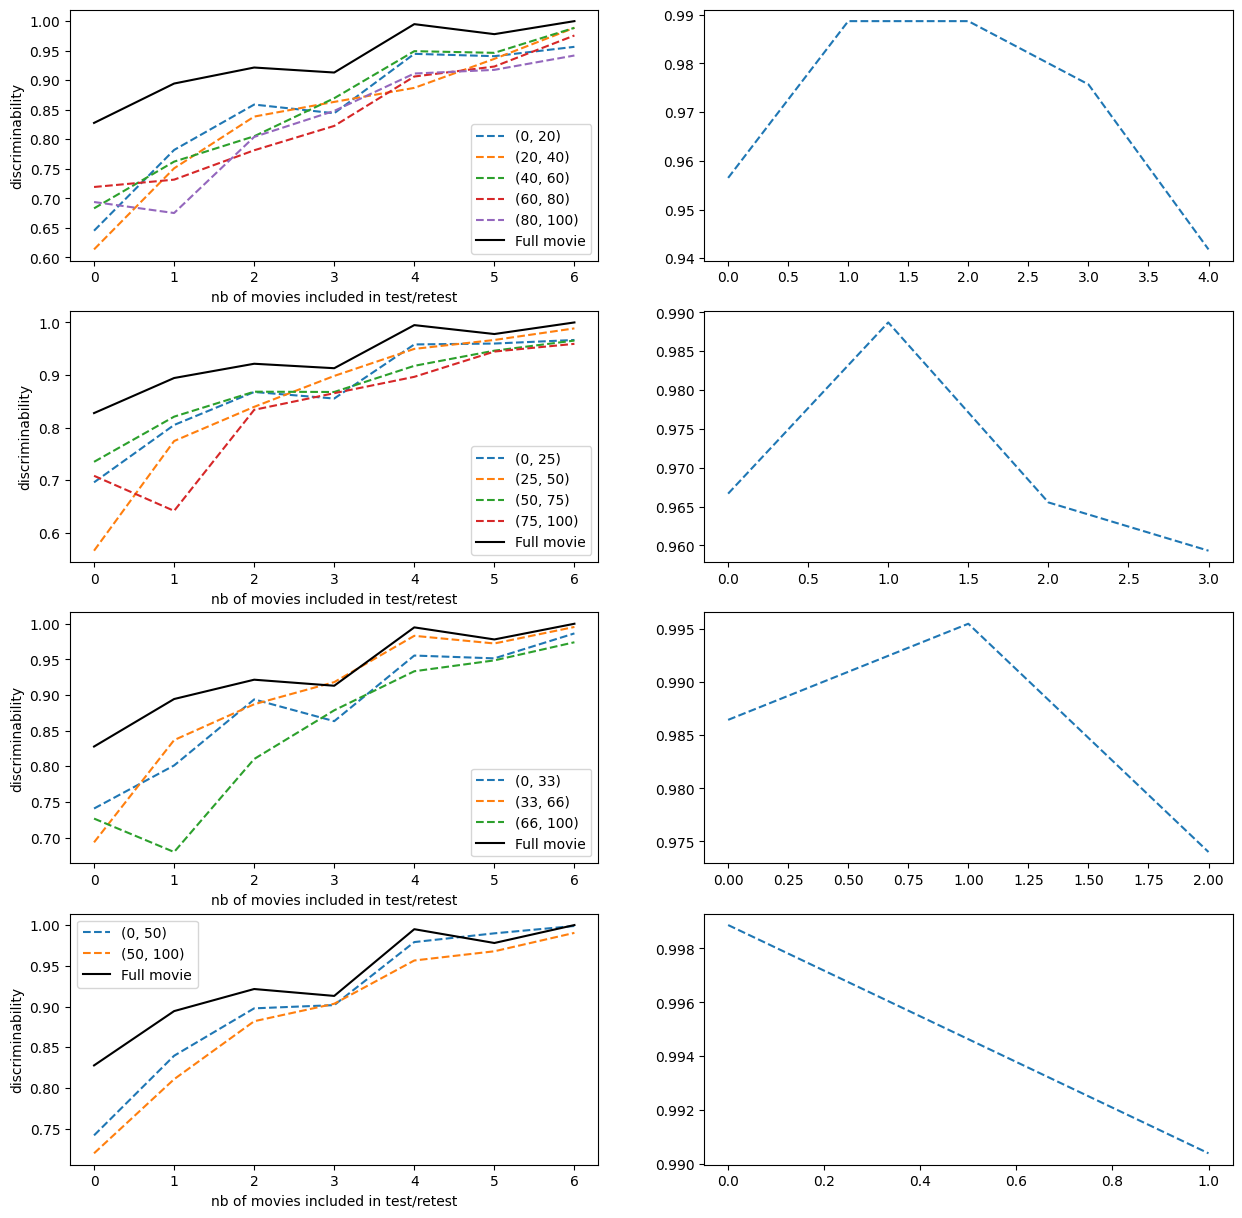

In [60]:
dis_bounds = per_fa_dis[1]
fig, ax = plt.subplots(4,2,figsize=(15,15))
for idx,bounds in enumerate([s20, s25, s33, s50]):
    for k in range(len(bounds)):
        ax[idx,0].plot(np.asarray([dis_bounds[s] for s in bounds])[k],linestyle='--', label=bounds[k])

    ax[idx,0].plot(np.asarray(step_disfull), label='Full movie', color='k')
    ax[idx,1].plot(np.asarray([dis_bounds[s][-1] for s in bounds]),linestyle='--')
    ax[idx,0].legend()
    ax[idx,0].set_xlabel("nb of movies included in test/retest")
    ax[idx,0].set_ylabel("discriminability")

Visual explanation of what discriminality is

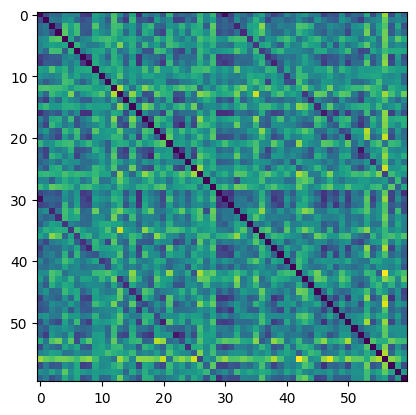

In [50]:
plt.imshow(dist_mat)